In [5]:
a = {'a':2, 'c':2, 'd':4}
z = {'a':1, 'c':2, 'z':4}

In [6]:
{**z, **a}

{'a': 2, 'c': 2, 'd': 4, 'z': 4}

In [26]:
import os
import blosc
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

In [2]:
src = './../MNIST_data'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    images = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    labels = blosc.unpack_array(file.read())

In [3]:
def create_train(opt, src, global_step, loss, it):
    def learning_rate(last, src):
        last = int(last)
        bound = list(np.linspace(0, last, len(range(2, last+1)), dtype=np.int32))
        values = [0.5 * 0.1/last * (1 + np.cos(np.pi * i / last)) for i in range(2, last+1)]
        var = [i for i in tf.trainable_variables() if src in i.name or 'dense' in i.name]
        
        return bound, values, var
    
    b, v, var = learning_rate(it, src)
    learning_rate = tf.train.piecewise_constant(global_step, b, v)
    
    return opt(learning_rate, 0.9, use_nesterov=True).minimize(loss, global_step, var)

## VGG-7 with FreezeOut 

In [4]:
it = 800
x = tf.placeholder(tf.float32, [None, 784], name='x')
x_as_pics = tf.reshape(x, shape=[-1, 28, 28, 1])


net1 = tf.layers.conv2d(x_as_pics, 64, (3, 3), (1, 1), name='Conv1', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

net1 = tf.layers.conv2d(net1, 64, (3, 3), (1, 1), name='Conv2', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
net1 = tf.layers.max_pooling2d(net1, 2, 2)

net1 = tf.layers.conv2d(net1, 128, (3, 3), (1, 1), name='Conv3', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
net1 = tf.layers.conv2d(net1, 128, (3, 3), (1, 1), name='Conv4', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
net1 = tf.layers.max_pooling2d(net1, 2, 2)


net1 = tf.layers.conv2d(net1, 256, (3, 3), (1, 1), name='Conv5', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
net1 = tf.layers.conv2d(net1, 256, (3, 3), (1, 1), name='Conv6', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
net1 = tf.layers.conv2d(net1, 256, (3, 3), (1, 1), name='Conv7', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
net1 = tf.layers.max_pooling2d(net1, 2, 2)

with tf.variable_scope('dense'):
    flat = tf.contrib.layers.flatten(net1)
    fc4 = tf.layers.dense(flat, 512, activation=tf.nn.relu, name='fc4')

    fc5 = tf.layers.dense(fc4, 10, name='fc5')

    y = tf.placeholder(tf.float32, [None, 10])

prob = tf.nn.softmax(fc5)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc5, labels=y, name='loss'))

train = []
global_steps = []
for i in tqn(range(7)):
    global_steps.append(tf.Variable(0, trainable=False))
    train.append(create_train(tf.train.MomentumOptimizer, 'Conv' + str(i), \
                              global_steps[-1], loss, it*(i/10 + 0.5)))

lables_hat = tf.cast(tf.argmax(fc5, axis=1), tf.float32, name='lables_hat')
lables = tf.cast(tf.argmax(y, axis=1), tf.float32, name='lables')
accuracy = tf.reduce_mean(tf.cast(tf.equal(lables_hat, lables), tf.float32), name='acc')

### Traning network

In [5]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

los, acc = [], []
var_i = []
for i in tqn(range(1, 900)):
    var, a, b = sess.run([train, tf.global_variables()[0], loss, accuracy],feed_dict={x:images[:100].reshape(-1, 784),
                                                                          y:labels[:100].reshape(-1,10)})[-3:]
    var_i.append(var)
    los.append(a)
    acc.append(b)

## VGG-7 without FreezeOut

In [9]:
x1 = tf.placeholder(tf.float32, [None, 784], name='x')


with tf.variable_scope('net2'):
    x_as_pics1 = tf.reshape(x1, shape=[-1, 28, 28, 1])
    
    net2 = tf.layers.conv2d(x_as_pics1, 64, (3, 3), (1, 1), name='Conv1', padding='SAME', \
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

    net2 = tf.layers.conv2d(net2, 64, (3, 3), (1, 1), name='Conv2', padding='SAME', \
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    net2 = tf.layers.max_pooling2d(net2, 2, 2)

    net2 = tf.layers.conv2d(net2, 128, (3, 3), (1, 1), name='Conv3', padding='SAME', \
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    net2 = tf.layers.conv2d(net2, 128, (3, 3), (1, 1), name='Conv4', padding='SAME', \
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    net2 = tf.layers.max_pooling2d(net2, 2, 2)


    net2 = tf.layers.conv2d(net2, 256, (3, 3), (1, 1), name='Conv5', padding='SAME', \
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    net2 = tf.layers.conv2d(net2, 256, (3, 3), (1, 1), name='Conv6', padding='SAME', \
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    net2 = tf.layers.conv2d(net2, 256, (3, 3), (1, 1), name='Conv7', padding='SAME', \
                               kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
    net2 = tf.layers.max_pooling2d(net2, 2, 2)

with tf.variable_scope('dense2'):
    flat2 = tf.contrib.layers.flatten(net2)
    fc24 = tf.layers.dense(flat2, 512, activation=tf.nn.relu, name='fc24')

    fc25 = tf.layers.dense(fc24, 10, name='fc25')

    y2 = tf.placeholder(tf.float32, [None, 10])

prob2 = tf.nn.softmax(fc25)

loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc25, labels=y2, name='loss2'))

train2 = tf.train.MomentumOptimizer(0.001, 0.9, use_nesterov=True).minimize(loss2)

lables_hat2 = tf.cast(tf.argmax(fc25, axis=1), tf.float32, name='lables_hat2')
lables2 = tf.cast(tf.argmax(y2, axis=1), tf.float32, name='lables2')
accuracy2 = tf.reduce_mean(tf.cast(tf.equal(lables_hat2, lables2), tf.float32), name='acc2')

### Train network

In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
los2, acc2 = [], []
for i in tqn(range(1, 600)):
    a, b = sess.run([train2, loss2, accuracy2],feed_dict={x1:images[:100].reshape(-1, 784),
                                                                          y2:labels[:100].reshape(-1,10)})[-2:]
    los2.append(a)
    acc2.append(b)

## Results

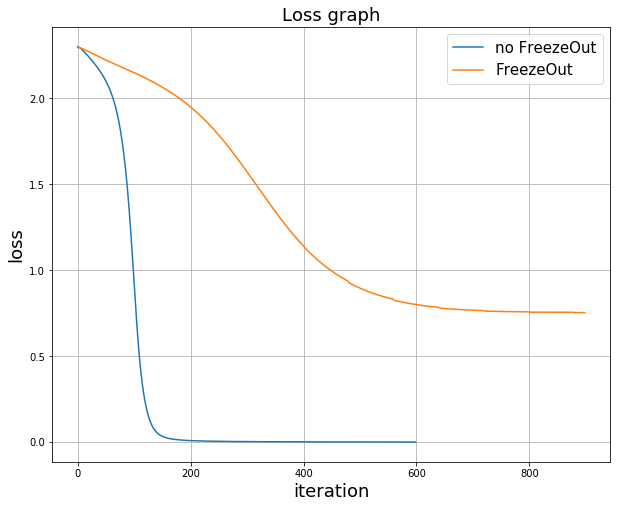

In [51]:
plt.figure(figsize = (10, 8))
plt.grid()
plt.title('Loss graph', fontsize=18)
plt.plot(los2, label='no FreezeOut')
plt.plot(los, label='FreezeOut')
plt.xlabel('iteration', fontsize=18)
plt.ylabel('loss', fontsize=18)
plt.legend(fontsize=15)

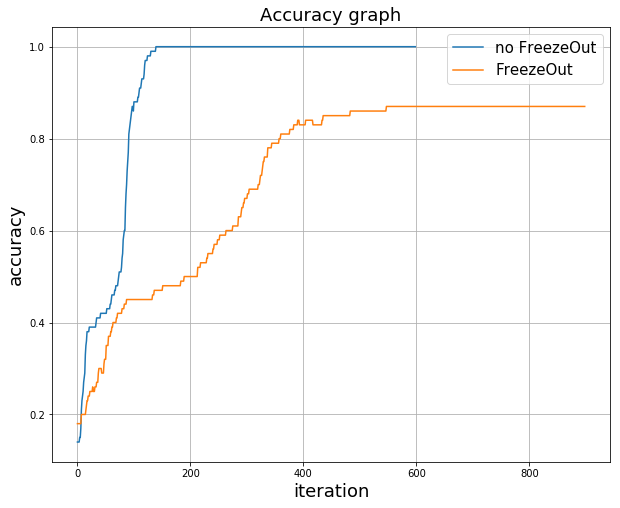

In [52]:
plt.figure(figsize = (10, 8))
plt.grid()
plt.title('Accuracy graph', fontsize=18)
plt.plot(acc2, label='no FreezeOut')
plt.plot(acc, label='FreezeOut')
plt.xlabel('iteration', fontsize=18)
plt.ylabel('accuracy', fontsize=18)
plt.legend(fontsize=15)